# Counting using deep learning regression gives value to ecological surveys

This document provides code to train and employ a CNN to count objects of interest by treating it as a regression problem. Example outputs (using the otolith dataset described in the paper) are provided as well. 

To run this script, the trainings images should be in a single folder ('data/Train'), the images for inference/testing should be in a single folder ('data/Test') and the image-level labels should be in a .csv file (e.g., 'data/Labels_Otolith_training_and_validation_set.csv').

In [1]:
# Import FastAI library
import fastai
from fastai.vision.all import *
print ('You are using FastAI version: ' + fastai.__version__)

You are using FastAI version: 2.0.13


The experiments in our paper were performed using  FastAI library version 2.0.13

In [2]:
filename = 'Your_Project_v01' # Insert your filename, for repeated experiments with different trainings hyperparameters (see below)
bs = 25 # For best performance, insert highest working batchsize here (limited by hardware) 
np.random.seed(2)

## Getting the data

In [3]:
# Get image paths
path = Path('data/Train');
path.ls()

(#3466) [Path('data/Train/A99-191-GK.jpg'),Path('data/Train/A99-193-GK.jpg'),Path('data/Train/A99-195-GK.jpg'),Path('data/Train/A99-197-GK.jpg'),Path('data/Train/A99-199-GK.jpg'),Path('data/Train/AM07-02-GK.jpg'),Path('data/Train/AM07-03-GK.jpg'),Path('data/Train/AM07-04-GK.jpg'),Path('data/Train/AM07-05-GK.jpg'),Path('data/Train/AM07-06-GK.jpg')...]

In [4]:
# Get image filenames
fnames = get_image_files(path)
fnames[:3]

(#3) [Path('data/Train/A99-191-GK.jpg'),Path('data/Train/A99-193-GK.jpg'),Path('data/Train/A99-195-GK.jpg')]

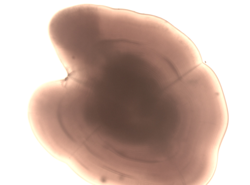

In [5]:
# Check single image
testfoto = str(fnames[1])
img = Image.open(testfoto)
img.to_thumb(250.250)

In [6]:
# Read datafile
df = pd.read_csv('data/Labels_Otolith_training_and_validation_set.csv')
df.head()

Filename  Label
0   EG09-02-GK.jpg     13
1   DO06-04-GK.jpg     14
2   NW09-45-GK.jpg     12
3   NW09-11-GK.jpg     10
4  BUS09-02-GK.jpg     13

## Creating a dataset

In [7]:
# Create dataset

def get_y(r): return r['Label']
def get_x(r): return path/r['Filename']

block = DataBlock(blocks=(ImageBlock, RegressionBlock), 
                  splitter=RandomSplitter(),
                  get_x = get_x, 
                  get_y = get_y,
                  item_tfms=Resize((770,1040), method='squish'), 
                  batch_tfms=[*aug_transforms( #https://docs.fast.ai/vision.augment#aug_transforms
                      mult=1.0, 
                      do_flip=True,
                      flip_vert=False,
                      max_rotate=0,
                      min_zoom=1.0,
                      max_zoom=1.01,
                      max_lighting=0.2,
                      max_warp=0,
                      p_affine=0.75,
                      p_lighting=0.75,
                      pad_mode='zeros'), 
                              Normalize.from_stats(*imagenet_stats)] 
                 )

In [8]:
dsets=block.datasets(df)

In [9]:
dls = block.dataloaders(df,bs=bs)

In [10]:
# Check tensor shapes
x,y=dls.one_batch()
x.shape,y.shape

(torch.Size([25, 3, 770, 1040]), torch.Size([25]))

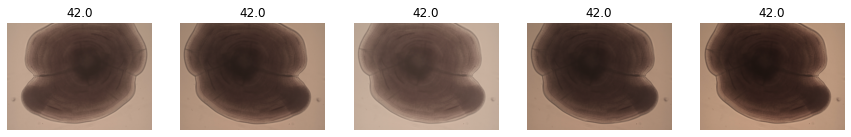

In [11]:
# Show data and check transforms
dls.show_batch(nrows=1, ncols=5, unique=True)

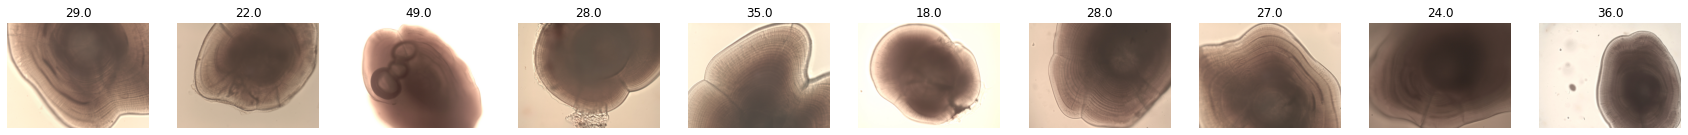

In [12]:
# Show data (= 1 bs) from validation set
dls.valid.show_batch(max_n=10, nrows=1)

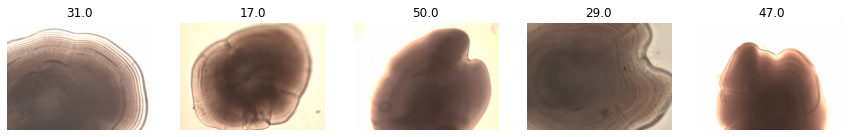

In [13]:
# Show data (= 1 bs) from training
dls.show_batch(nrows=1, ncols=5)

In [14]:
# nice tool to debug datablock
#block.summary(path)

## Train model

In [15]:
# Define Huber loss function (i.e. SmoothL1Loss)
def Huber(*args, axis=-1, floatify=True, **kwargs):
    "Same as `nn.SmoothL1Loss`, but flattens input and target."
    return BaseLoss(nn.SmoothL1Loss, *args, axis=axis, floatify=floatify, is_2d=False, 
                    **kwargs, flatten=True)

In [16]:
# Create Learner
learn = cnn_learner(dls, resnet18, loss_func=Huber(), # Different ResNets and Loss functions can be specified here
                    metrics=(mse,rmse,mae));
learn.model = torch.nn.DataParallel(learn.model) # Parallels computations over multiplle GPUs. This can be turned off
learn.save(filename + '_stage-1_00'); # Saves pretrained model, for repetitive trials
print('This is Ring Regression version: ' + filename) # see top
print('The batchsize is set at:', bs) # see top
print('The loss function is:', learn.loss_func) # To double check current loss func

This is Ring Regression version: Your_Project_v01
The batchsize is set at: 25
The loss function is: FlattenedLoss of SmoothL1Loss()


#### Stage 1 (frozen model)

At this first stage, only the added (fully connected) layers are trained.

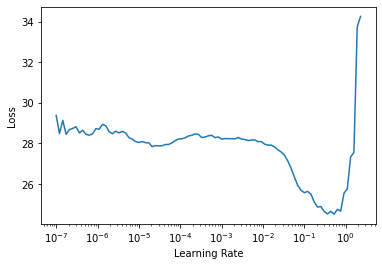

In [17]:
# LR finder for frozen model
lr_min,lr_steep = learn.lr_find()

In [18]:
# Fit frozen network (i.e. only last layers), with callbacks
learn.load(filename + '_stage-1_00')
learn.fit_one_cycle(3,slice(3e-2), # specify number of cycles and LR
                    cbs=SaveModelCallback(monitor='valid_loss', fname ='TempBestModel')
                   )

Better model found at epoch 0 with valid_loss value: 5.593927383422852.
Better model found at epoch 1 with valid_loss value: 3.8452444076538086.
Better model found at epoch 2 with valid_loss value: 3.2721760272979736.


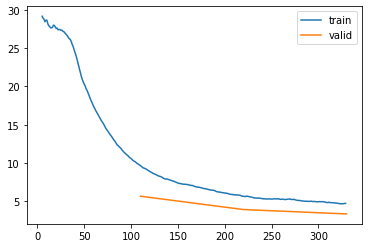

In [19]:
# Save resulting best performing model
learn.load('TempBestModel')
learn.save(filename + '_stage-1_01')
learn.recorder.plot_loss()

In [20]:
# Repeat above two steps, with different number of cycles and/or LR
learn.load(filename + '_stage-1_00')
learn.fit_one_cycle(25,slice(5e-2), 
                    cbs=SaveModelCallback(monitor='valid_loss', fname ='TempBestModel')
                   )

Better model found at epoch 0 with valid_loss value: 5.2312235832214355.
Better model found at epoch 1 with valid_loss value: 4.233163833618164.
Better model found at epoch 2 with valid_loss value: 3.9975364208221436.


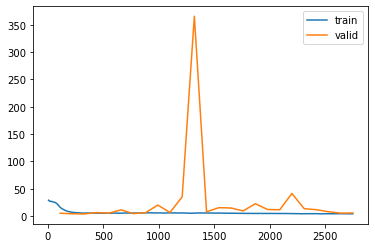

In [21]:
# Same as above, save resulting best performing model, but with different filename
learn.load('TempBestModel')
learn.save(filename + '_stage-1_02')
learn.recorder.plot_loss()

In [22]:
# The above two steps can be repeated/copied any number of times, 
# with various number of cycles and/or LR, until the performance is satisfactory.
# Change the filename extension ( + '_stage-1_XX') accordingly.

# After this, select best stage-1 (frozen) model and save:
learn.load(filename + '_stage-1_02') # Manually select best stage 1 model based on results above
learn.save(filename + '_stage-1_Best')

Path('models/Your_Project_v01_stage-1_Best.pth')

#### Stage 2 (unfrozen model)

At this second stage, the whole model is unfrozen, and all layers are trained.

In [23]:
# Load best performing Stage_1 model
learn.load(filename + '_stage-1_Best')
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.5848931980144698e-06)

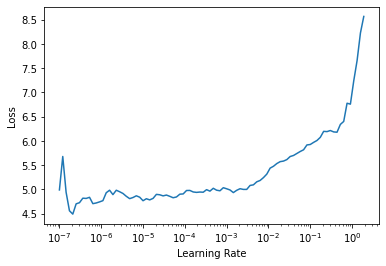

In [24]:
# LR finder for unfrozen model 
learn.lr_find()

In [25]:
# Fit unfrozen network (i.e. all layers), with callbacks
learn.load(filename + '_stage-1_Best')
learn.unfreeze()
learn.fit_one_cycle(10,slice(1e-6,1e-4), 
                    cbs=SaveModelCallback(monitor='valid_loss', fname ='TempBestModel')
                   )

Better model found at epoch 0 with valid_loss value: 3.7685399055480957.
Better model found at epoch 1 with valid_loss value: 3.3624284267425537.
Better model found at epoch 2 with valid_loss value: 3.088758707046509.
Better model found at epoch 3 with valid_loss value: 2.9347119331359863.
Better model found at epoch 4 with valid_loss value: 2.866436004638672.
Better model found at epoch 5 with valid_loss value: 2.746260643005371.
Better model found at epoch 8 with valid_loss value: 2.7365307807922363.


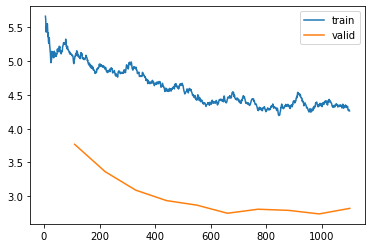

In [26]:
# Save resulting best performing model
learn.load('TempBestModel')
learn.save(filename + '_stage-2_01')
learn.recorder.plot_loss()

In [27]:
# Repeat above two steps, with different number of cycles and/or LR
learn.load(filename + '_stage-1_Best')
learn.unfreeze()
learn.fit_one_cycle(50,slice(9e-7,9e-5), 
                    cbs=SaveModelCallback(monitor='valid_loss', fname ='TempBestModel')
                   )

Better model found at epoch 0 with valid_loss value: 3.8238749504089355.
Better model found at epoch 2 with valid_loss value: 3.738367795944214.
Better model found at epoch 3 with valid_loss value: 3.7078726291656494.
Better model found at epoch 4 with valid_loss value: 3.2793328762054443.
Better model found at epoch 5 with valid_loss value: 3.191129446029663.
Better model found at epoch 7 with valid_loss value: 2.957399845123291.
Better model found at epoch 8 with valid_loss value: 2.9200727939605713.
Better model found at epoch 11 with valid_loss value: 2.8769655227661133.
Better model found at epoch 12 with valid_loss value: 2.8195061683654785.
Better model found at epoch 14 with valid_loss value: 2.811343193054199.
Better model found at epoch 15 with valid_loss value: 2.6859261989593506.
Better model found at epoch 16 with valid_loss value: 2.6771700382232666.
Better model found at epoch 19 with valid_loss value: 2.637165069580078.
Better model found at epoch 20 with valid_loss val

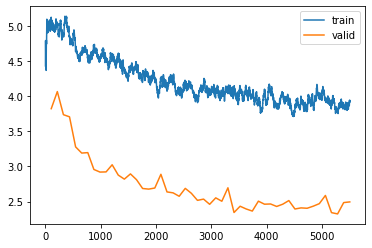

In [28]:
# Same as above, save resulting best performing model, but with different filename
learn.load('TempBestModel')
learn.save(filename + '_stage-2_02')
learn.recorder.plot_loss()

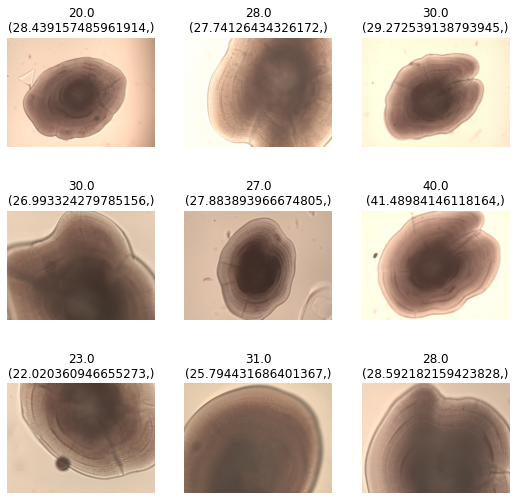

In [29]:
# The above two steps can be repeated any number of times, 
# with various number of cycles and/or LR, until the performance is satisfactory.
# Remember to change the filename extension ( + '_stage-2_XX') accordingly.

# After this, select best stage-2 (unfrozen) model, save and show results (on validation set):
learn.load(filename + '_stage-2_02') # select best stage 2 model
learn.save(filename + '_stage-2_Best') 
learn.show_results() # this shows predictions on the (randomly selected) validation set

# Inference

By using the code below, predictions can be made on a test set of unseen images

In [30]:
# Define Path towards test images
PathImgs = Path('data/Test'); # the folder 'Test' should contain the images for inference
print ('The path to the images is:', PathImgs);

The path to the images is: data/Test


In [31]:
# Load model
learn.load(filename + '_stage-2_Best') 

### Single image

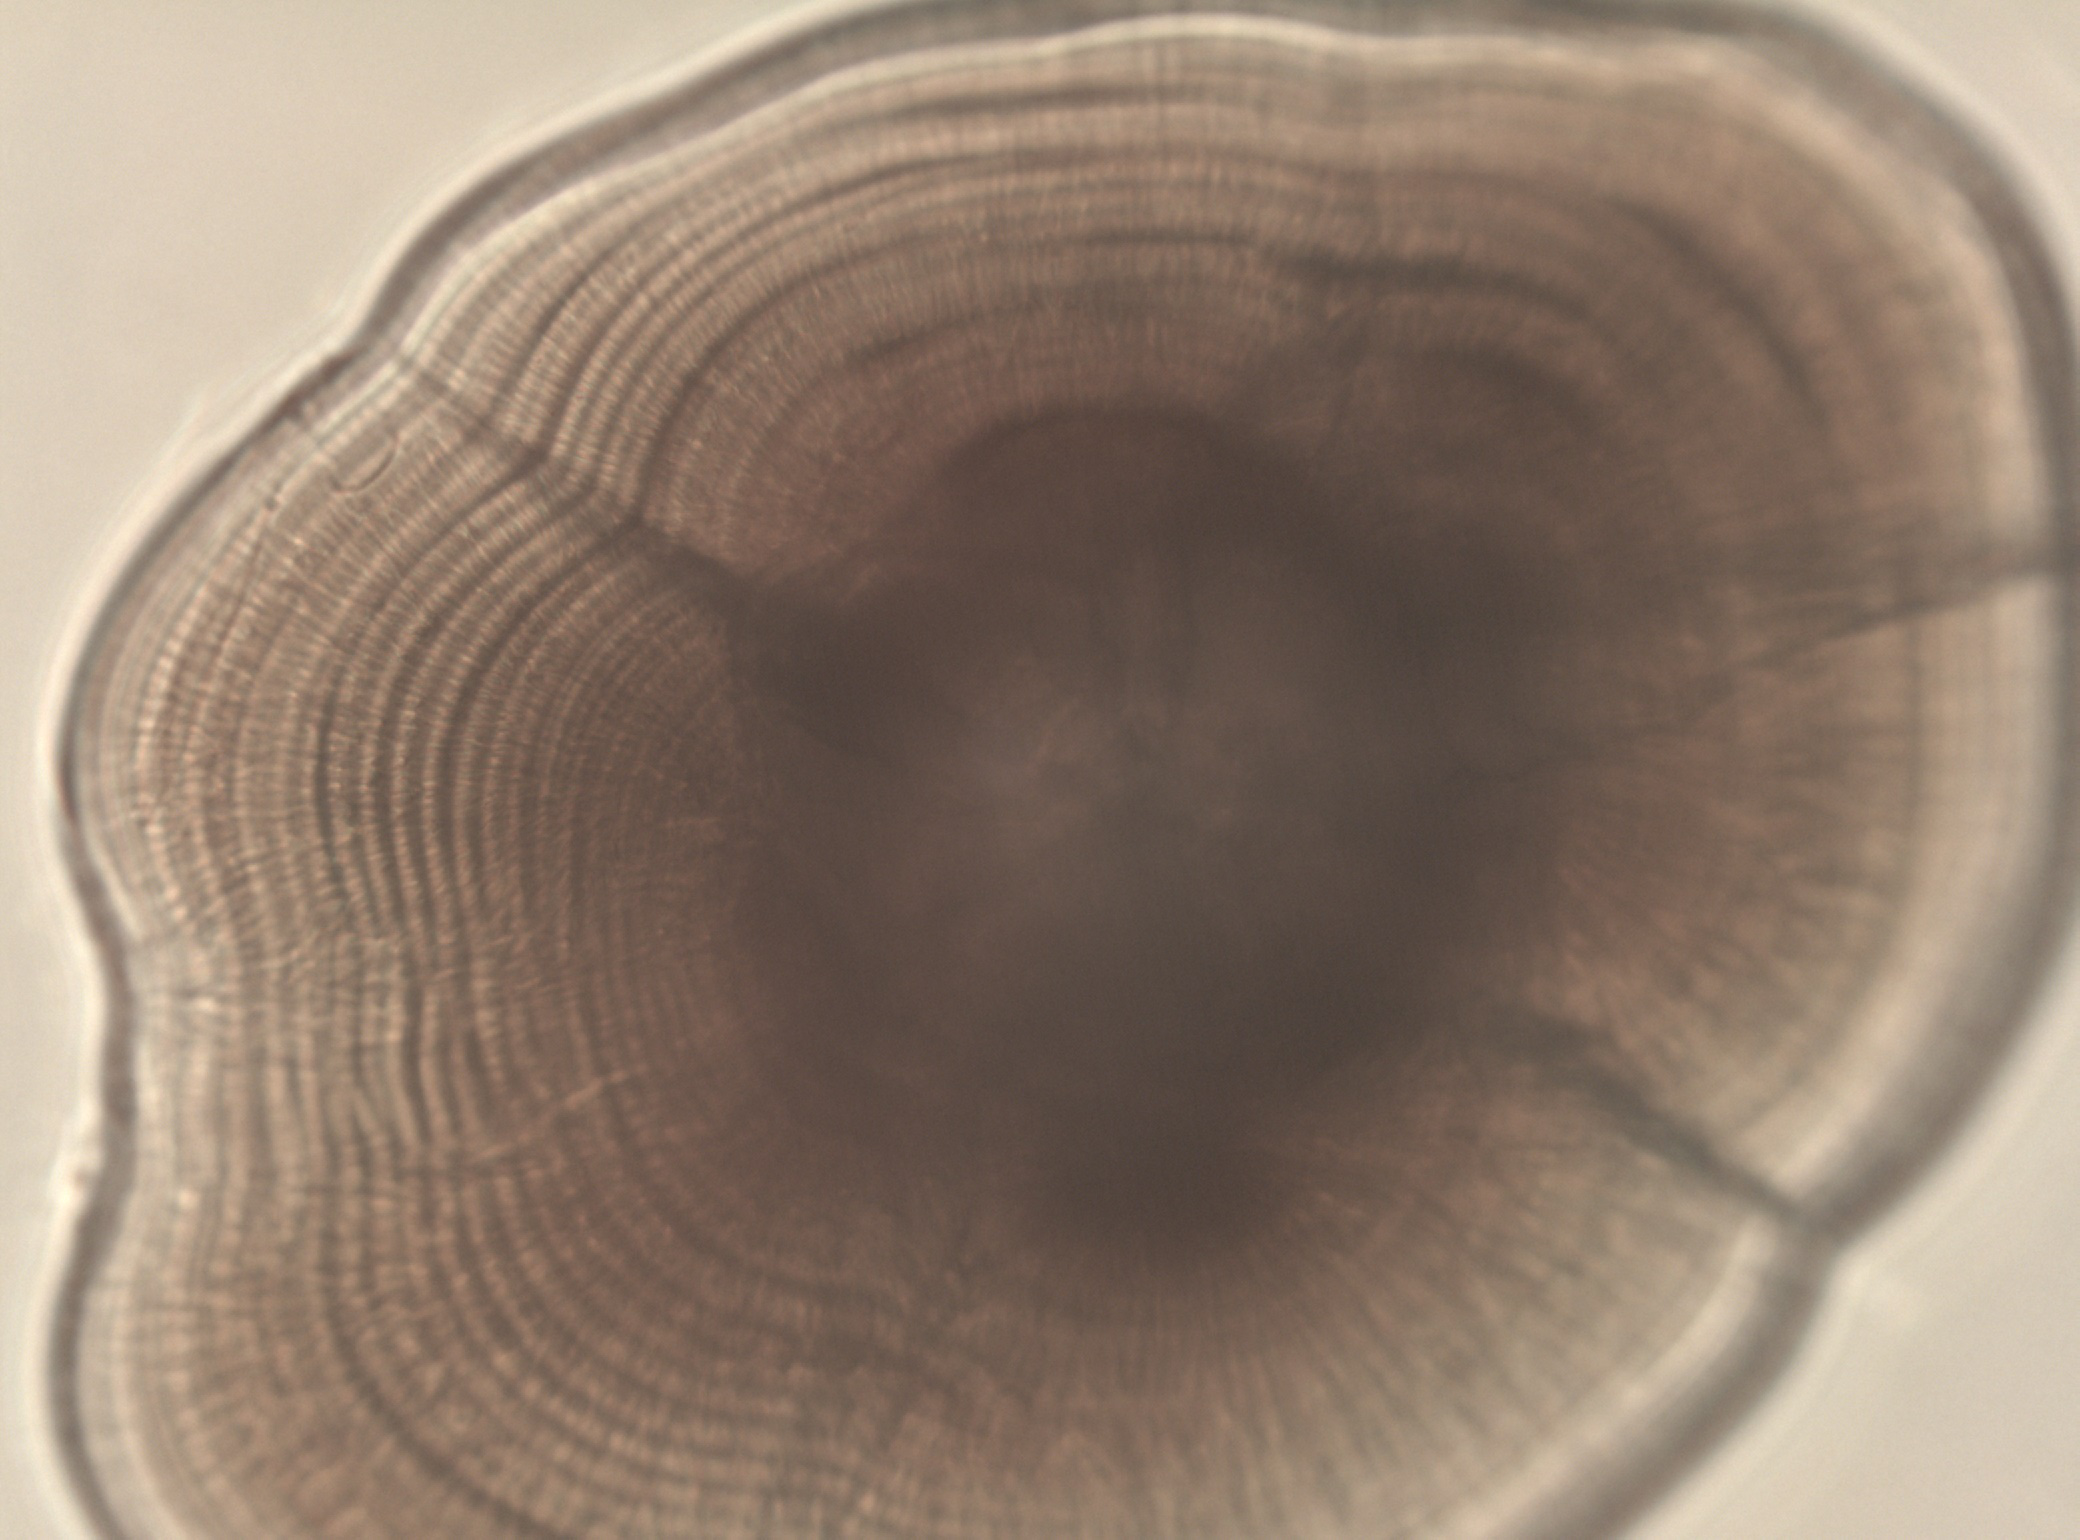

In [32]:
# Get image to make prediction on and plot
img = PathImgs/'AM08-08-GK.jpg' # manually name image to make prediction on
Image.open(img)

In [33]:
# Get prediction
learn.predict(img)

((22.95615005493164), tensor([22.9562]), tensor([22.9562]))

### Multiple images

In [34]:
# Get images to make predictions on 
imgs = get_image_files(PathImgs);imgs

(#120) [Path('data/Test/AM08-08-GK.jpg'),Path('data/Test/AM08-100-GK.jpg'),Path('data/Test/AM08-110-GK.jpg'),Path('data/Test/AM08-71-GK.jpg'),Path('data/Test/AM10-58-GK.jpg'),Path('data/Test/BA09-102-GK.jpg'),Path('data/Test/BA09-18-GK.jpg'),Path('data/Test/BA09-39-GK.jpg'),Path('data/Test/BA99-05-GK.jpg'),Path('data/Test/BA99-13-GK.jpg')...]

In [35]:
# Create image batch for predicting
dl = learn.dls.test_dl(imgs)

In [36]:
# Get predictions for image batch (for very large dataset this takes some time)
preds, ignored1, ignored2 = learn.get_preds(dl=dl, with_decoded=True)

In [37]:
# Create table (i.e. dataframe) with predictions
testdf = pd.DataFrame() # creates empty table
testdf['id'] = imgs.items # adds filenames & paths to table
testdf['label']=preds.numpy() # adds predictions to table
testdf # plots table

id      label
0     data/Test/AM08-08-GK.jpg  22.956146
1    data/Test/AM08-100-GK.jpg  33.553585
2    data/Test/AM08-110-GK.jpg  33.524612
3     data/Test/AM08-71-GK.jpg  23.511864
4     data/Test/AM10-58-GK.jpg  16.013777
..                         ...        ...
115  data/Test/ZOL08-23-GK.jpg  24.337635
116  data/Test/ZOL09-51-GK.jpg  30.946060
117  data/Test/ZOL09-53-GK.jpg  34.093056
118  data/Test/ZOL09-54-GK.jpg  31.226585
119  data/Test/ZOL09-81-GK.jpg  38.114960

[120 rows x 2 columns]

In [38]:
# Export table with predictions to .csv file 
testdf.to_csv('Preds.csv', index=False, float_format='%.9f')

# Export

The remaining sections ('Export' and 'Heatmaps') do not work when using multiple GPUs in parallel. Therefore, at this stage, make sure that torch.nn.DataParallel(learn.model) is not applied to the learner object.

In [39]:
# Redefine a learner, without parallel GPU computation
learn = cnn_learner(dls, resnet18, loss_func=Huber(), 
                    metrics=(mse,rmse,mae));

# Load best performing model
learn.load(filename + '_stage-2_Best') 

In [40]:
# Export best model to .pkl format
learn.export(fname='YourModel.pkl') # Remember, this cannot run when learner is in parallel (see above: learn.model = torch.nn.DataParallel(learn.model))

# Heatmaps (CAM)

In [41]:
# Create Hook class 
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [42]:
# Define model name for import
modelex ='YourModel.pkl'

In [43]:
# Define path towards test images for heatmap
PathImgs = Path('data/Test');

In [44]:
# Load model (.pkl file, exported above)
learn = load_learner(modelex);learn

In [45]:
# Load images

# Two options are provided below: 
# 1) make a heatmap for a manually defined single image, or
# 2) make heatmaps for a batch (size = batchsize) of images



############# 1) For a Single Image, run this: ##############

# Define image name manually
ImgID = 'TE09-72-GK.jpg'

# Single Image
# Get path of image (single)
img = PathImgs/ImgID; img

# Load image (single)
x, = first(learn.dls.test_dl(str(img)))

# For single image, xindex is alway 0
xindex = 0



# ############## 2) For Multiple Images, run this: ##############

# # Get path of images (multiple), can later be indexed into
# imgs = get_image_files(PathImgs);imgs 

# # Load images (multiple)
# x, = first(learn.dls.test_dl(imgs))

# # Which image out of the batch do you want to display (i.e. index of x)?
# # Maximum value of xindex = batchsize (defined at top)
# xindex = 1

# # Get filepath of image to plot
# img = imgs[xindex]

In [46]:
# Attach Hook to last layer of network
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [47]:
# Feed batch through model
with torch.no_grad(): output = learn.model.eval()(x)

In [48]:
# Access stored activations
act = hook_output.stored[xindex]

# # See predictions for all images in batch (i.e. x)
# output

In [49]:
# check shape of x [number of imgs, layers (i.e. RGB), height img, width img]
x.shape

torch.Size([1, 3, 770, 1040])

In [50]:
# dot product of weight matrix
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([1, 25, 33])

The filename and path is: data/Test/TE09-72-GK.jpg
The prediction is: 32.14


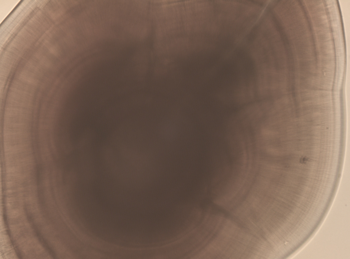

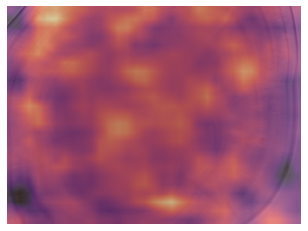

In [51]:
# Plot heatmap
x_dec = TensorImage(dls.train.decode((x,))[0][xindex])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[0].detach().cpu(), alpha=0.6, extent=(0,x.shape[3],x.shape[2],0),
              interpolation='bilinear', cmap='magma');

# Some print functions and plot original to display along with heatmap
print ('The filename and path is:', img);
print ('The prediction is:', round(output[xindex].item(),2));
#print('The label is', ' '.join(re.findall(r'(\d+)_...\d+.JPG$', imgs[xindex].name))) # print label (regex) - (for .csv no code yet)
Image.open(img).to_thumb(x.shape[3]/2.2,x.shape[2]/2.2)